# Train Model on Training Set and Check Predictions on Both Training and Validation Sets

In [1]:
import napari
from napari.utils import nbscreenshot
from pathlib import Path
from skimage.io import imread
from skimage.measure import label
import napari_simpleitk_image_processing as nsitk
import numpy as np
import apoc
from natsort import natsorted
import json

from utilities import refine_labels

## 1. Get list of paths of training and validation images

In [2]:
folder_path = r"D:\Datasets\Claudia Dagostino\data"

In [3]:
folder_path = Path(folder_path)
training_set_folder_path = folder_path / 'train'
validation_set_folder_path =  folder_path / 'validation'
training_annotations_folder_path = folder_path / 'train_annotations'
train_images_paths = natsorted([path for path in training_set_folder_path.iterdir()])
annotation_images_paths = natsorted([path for path in training_annotations_folder_path.iterdir()])
validation_images_paths = natsorted([path for path in validation_set_folder_path.iterdir()])
existing_model = False

# Load min_area json file, get min_area key-value par and store it in min_area variable
# print message if file is not found
try:
    with open(folder_path / 'min_area.json') as f:
        min_area = json.load(f)['min_area']
# Handle exception in case file is not found
except FileNotFoundError:
    print(f"Warning! 'min_area.json' file not found in {folder_path}! Using default value of 1000.")
    min_area = 1000

print(f"min_area = ", min_area)


min_area =  1000


## 2. Train model on all annotated images
Derived from https://github.com/haesleinhuepf/apoc/blob/main/demo/demp_pixel_classifier_continue_training.ipynb.
First, look if a model file (except for the temp_model.cl) is already there (in the main folder). If it is, it will use that model instead of creating and training a new one.

In [4]:
# define features: original image, a blurred version and an edge image
features = ("original gaussian_blur=0.5 difference_of_gaussian=0.5 laplace_diamond_of_gaussian_blur=0.5 difference_of_gaussian=0.5 " +\
            "gaussian_blur=1 difference_of_gaussian=1 laplace_diamond_of_gaussian_blur=1 difference_of_gaussian=1 " +\
            "gaussian_blur=2 difference_of_gaussian=2 laplace_diamond_of_gaussian_blur=2 difference_of_gaussian=2 " +\
            "gaussian_blur=5 difference_of_gaussian=5 laplace_diamond_of_gaussian_blur=5 difference_of_gaussian=5 " +\
            "gaussian_blur=10 difference_of_gaussian=10 laplace_diamond_of_gaussian_blur=10 difference_of_gaussian=10")

cl_filepath = [path for path in folder_path.iterdir() if (path.suffix == '.cl') and (path.stem != 'temp_model')]
if cl_filepath:
    cl_filepath = cl_filepath[0]
    existing_model = True
    print(f"Found existing (non-test) model in main file called '{cl_filepath.stem}'. Skipping training and using that model instead for predictions.")
else:
    print("No model found in main folder. Creating a new file ('my_model.cl') to be trained with training images and annotations.")

    # this is where the model will be saved
    cl_filepath = folder_path / 'my_model.cl'
    apoc.erase_classifier(cl_filepath)
clf = apoc.PixelClassifier(opencl_filename=cl_filepath)

Found existing (non-test) model in main file called 'my_model'. Skipping training and using that model instead for predictions.


Only train if no existing model is found.

In [5]:
if existing_model == False:
    for image_path, annotations_path in zip(train_images_paths, annotation_images_paths):
        image = imread(image_path)
        annotations = imread(annotations_path)

        # Provide standard deviation filter as extra channel
        extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
        extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
        image_stack = np.stack([image, extra_channel])

        # features = apply_filters(image)
        clf.train(features, annotations, image_stack, continue_training=True)
else:
    print("Model found in folder, skipping training.")

Model found in folder, skipping training.


## 3. Check result and performance on train and validation data

In [6]:
viewer = napari.Viewer()
for image_path in validation_images_paths:
    image = imread(image_path)
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])
    result = clf.predict(image=image_stack)
    # Post-process labels
    labels_post_processed = refine_labels(result, min_area)
    # Add images to napari viewer
    viewer.add_image(image, name=image_path.stem + '_validation_set')
    # viewer.add_labels(labels)
    viewer.add_labels(labels_post_processed, name='Predictions of ' + image_path.stem + '_validation_set')

for image_path in train_images_paths:
    image = imread(image_path)
    extra_channel = nsitk.laplacian_of_gaussian_filter(image, 1.0)
    extra_channel = nsitk.standard_deviation_filter(extra_channel, 1, 1, 0)
    image_stack = np.stack([image, extra_channel])
    result = clf.predict(image=image_stack)
    # Post-process labels
    labels_post_processed = refine_labels(result, min_area)
    # Add images to napari viewer
    viewer.add_image(image, name=image_path.stem + '_training_set')
    # viewer.add_labels(labels)
    viewer.add_labels(labels_post_processed, name='Predictions of ' + image_path.stem + '_training_set')

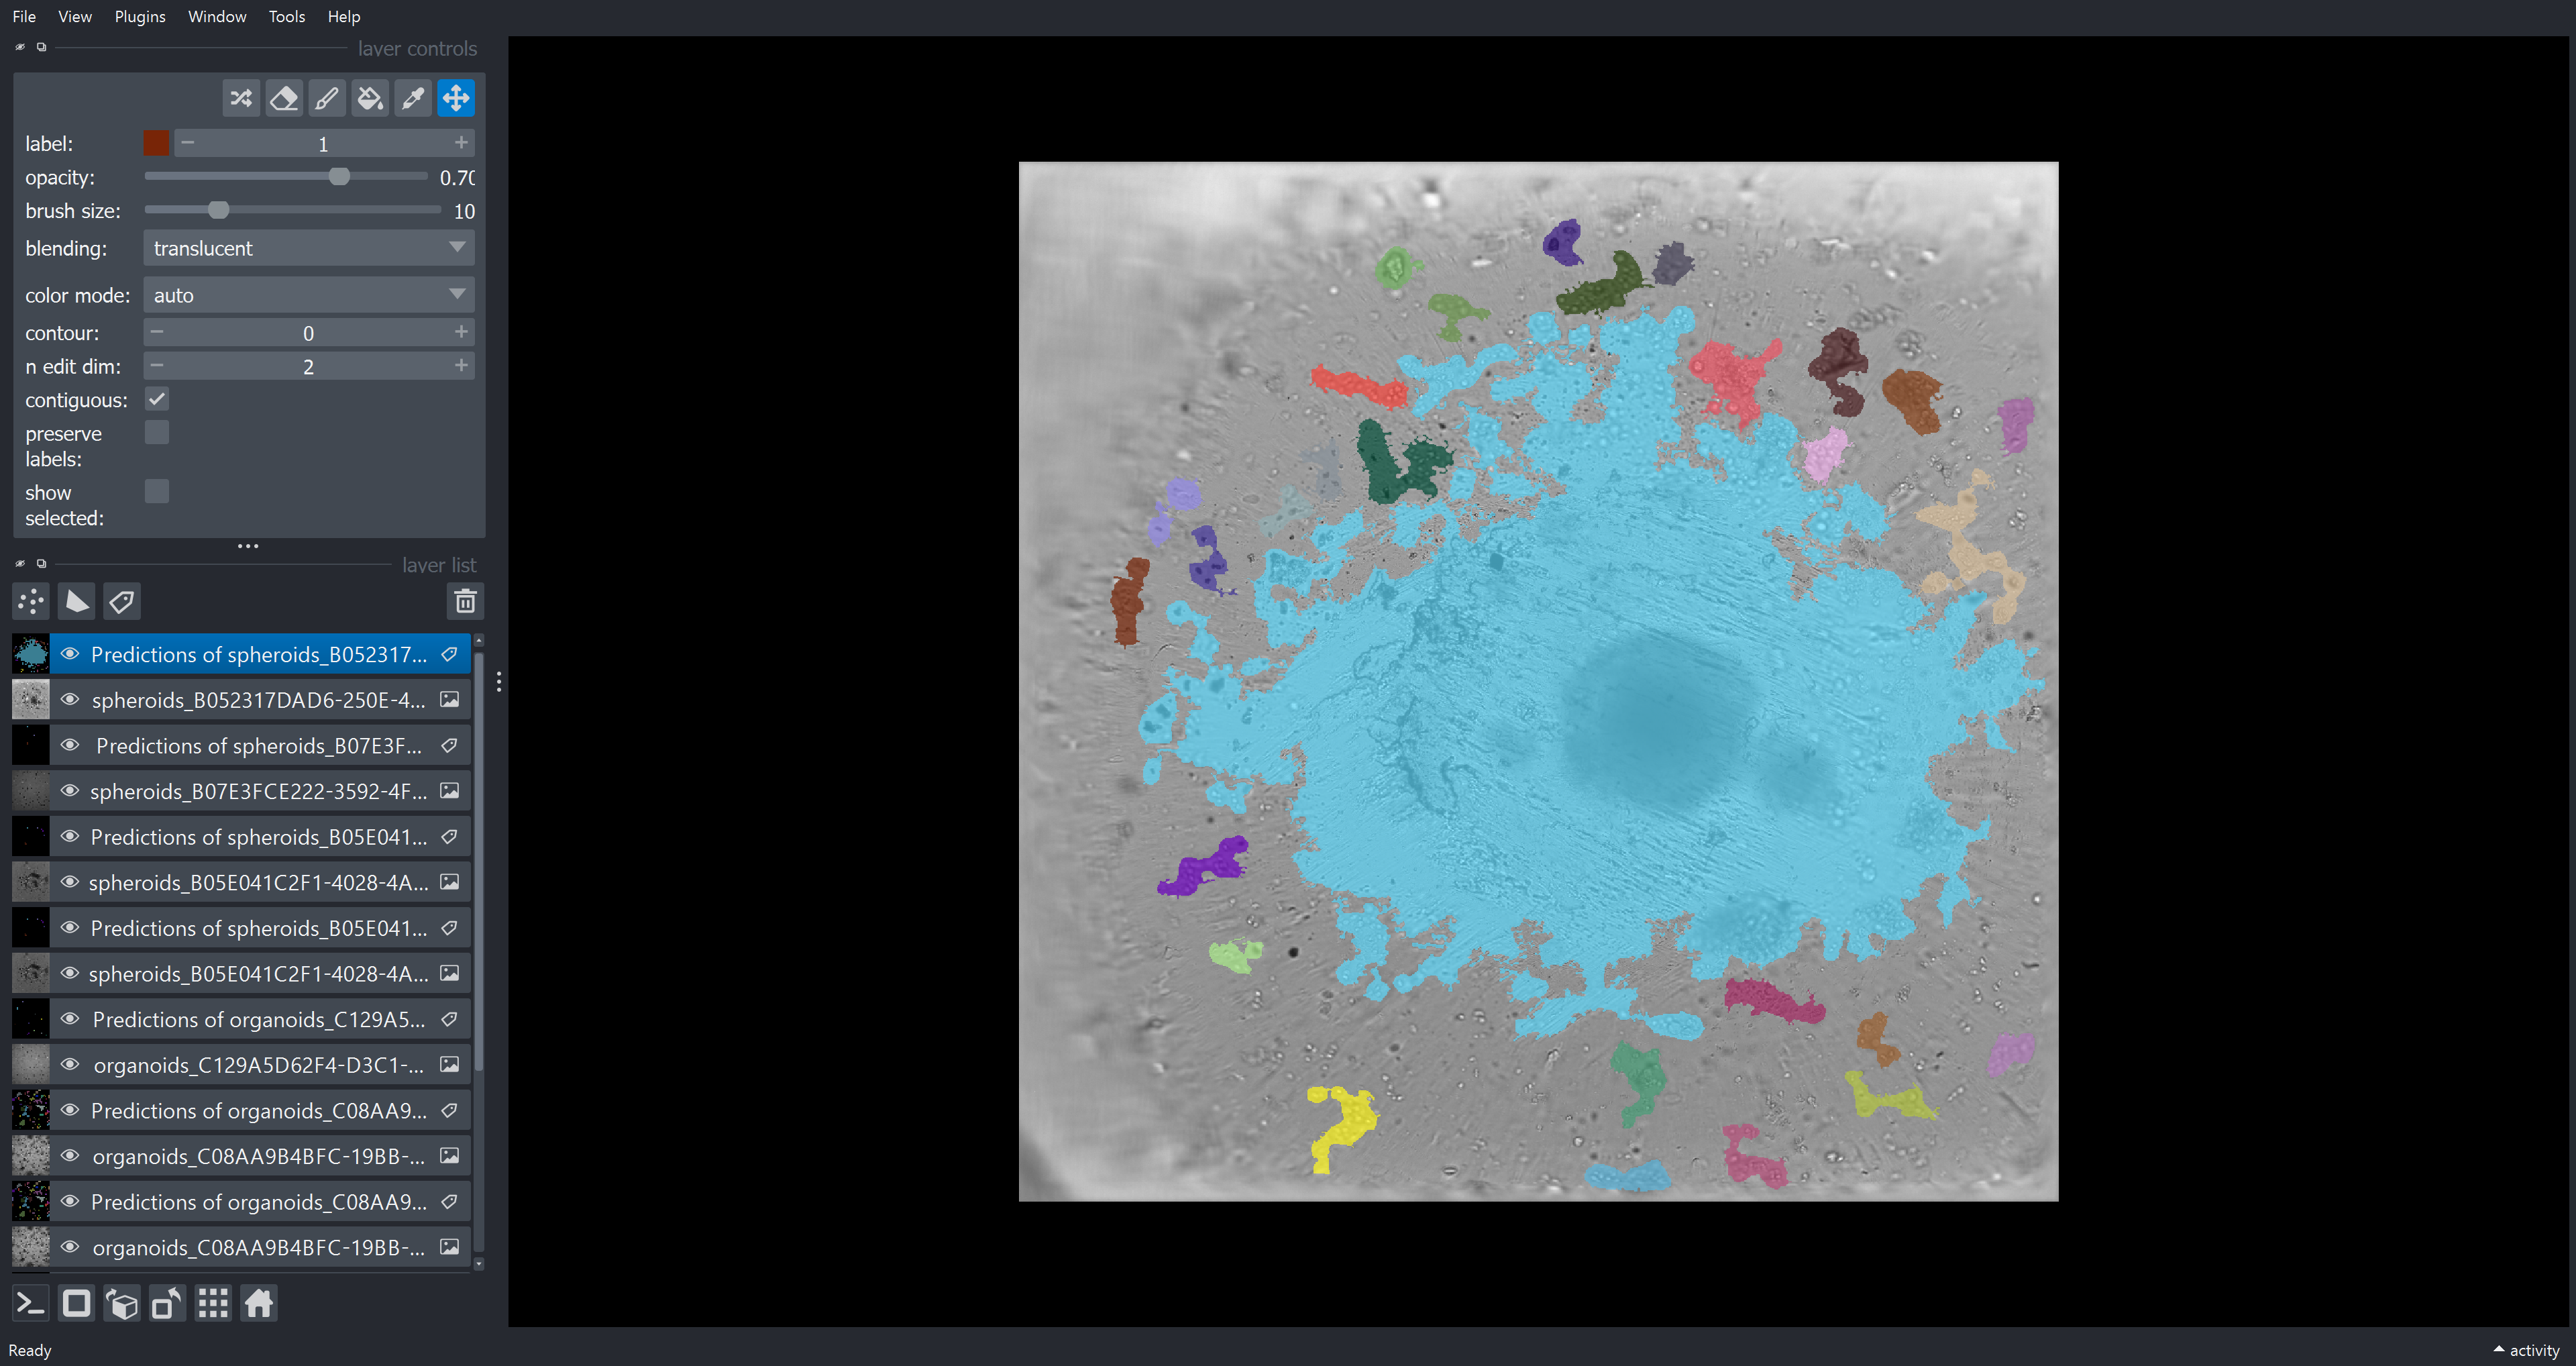

In [7]:
nbscreenshot(viewer)

If results are unsatisfactory, go back to previous notebook (Image_annotation) and provide some extra annotations.